In [1]:
using PyPlot
using Random

In [3]:
struct controls
    reduce::Array{Float64,1}
    remove::Array{Float64,1}
    geoeng::Array{Float64,1}
    adapt::Array{Float64,1}
end

nondim_linear(t::Array) = (t .- t[1])/(t[end] - t[1]);

function init_linear_controls(t)
    c = controls(
        nondim_linear(t),
        nondim_linear(t)/3.,
        nondim_linear(t)/8.,
        nondim_linear(t)/10.
    )
    return c
end

struct ClimateModel
    name::String
    ECS::Float64
    controls::controls
end


In [7]:
t = Array(2020:1.:2100);
c = init_linear_controls(t)
model = ClimateModel("test", 3.0, c);

In [10]:
function optimize_climate(ECS::Float64)
    
    # discretization
    t = Array(2020:1.:2100);

    # CO2 concentration (ppm) at t[1]
    c_00 = 415.;


    # economic parameters
    β = 1.; # damage parameter (10^12 $ / C^2)
    ρ = 0.02 # utility discount rate

    GWP = 100. # Global World Product (10^12 $/yr)
    C_ϕ = 0.05*GWP; # carbon removal (10^12 $/yr)
    C_φ = 0.05*GWP; # emissions reductions (10^12 $/yr)
    C_χ = 0.1*GWP; # adaptation (10^12 $/yr)
    C_λ = 0.15*GWP; # geoengineering (10^12 $/yr)

    # baseline emissions scenarios
    q = 5. .* ones(size(t)); # emissions scenario
    q[40:81] .= q[1] * (40. .-(0.:1.:41.))/40.
    q[81:end] .= 0.

    # physical climate parameters
    ϵ = ECS/log(2.); # Transient Warming Parameter
    δT_00 = 1.1; # Warming at t[1] since preindustrial

    c_0 = c_00 .+ cumsum(q); # cumulative CO2 concentrations (ppm)
    δT_0 = δT_00 .+ ϵ.*log.(c_0/c_00); # warming due to baseline emissions scenario

    D_0 = β .* δT_0.^2; # baseline damages (10^12 $)
    discounting = (1. / (1. + ρ)).^(t.-t[1])

    nondim_linear(t::Array) = (t .- t[1])/(t[end] - t[1]);
    ϕ = nondim_linear(t); # carbon removal
    ϕ[t.>2100] .= ϕ[t.==2100]
    φ = nondim_linear(t)/3.; # emissions reductions
    χ = nondim_linear(t)/8.; # adaptation
    λ = nondim_linear(t)/10.; # geoengineering

    f_low(α::Array) = (α ./ (1. .+ α)).^2 # shape of individual cost functions
    f_med(α::Array) = α.^2 # shape of individual cost functions
    f_high(α::Array) = (α ./ (1. .- α)).^2 # shape of individual cost functions


    c(ϕ::Array, φ::Array) = c_0 .- cumsum(q .* φ) .- cumsum(q[1] .* ϕ);
    δT(ϕ::Array, φ::Array) = δT_00 .+ ϵ.*log.(c(ϕ,φ)./c_00);

    D(ϕ::Array, φ::Array, χ::Array, λ::Array) = (1. .- χ) .* β .* δT(ϕ, φ).^2 .* (1. .- λ).^2;

    C(ϕ::Array, φ::Array, χ::Array, λ::Array) = C_λ.*f_med(λ) .+ C_ϕ.*f_med(ϕ) .+ C_φ.*f_med(φ) .+ C_χ.*f_med(χ);
    T(ϕ::Array, φ::Array, χ::Array, λ::Array) = (
        sum((C(ϕ, φ, χ, λ) .+ D(ϕ, φ, χ, λ)) .* (1. / (1. + ρ)).^(t.-t[1])) .+
        200. * (sum(diff(ϕ).^2) .+ sum(diff(φ).^2) .+ sum(diff(χ).^2) .+ sum(diff(λ).^2)) .+
        200. .* (ϕ[1].^2 .+ φ[1].^2 .+ χ[1].^2 .+ λ[1].^2)
    );

    function ∇T(ϕ::Array, φ::Array, χ::Array, λ::Array)
        Δα = 1.e-5
        ∂T∂ϕ = zeros(size(ϕ))
        ∂T∂φ = zeros(size(φ))
        ∂T∂χ = zeros(size(χ))
        ∂T∂λ = zeros(size(λ))
        for i=1:length(ϕ)
            δα = zeros(size(ϕ))
            δα[i] = Δα
            ∂T∂ϕ[i] = (T(ϕ.+δα,φ,χ,λ) .- T(ϕ,φ,χ,λ))/Δα
            ∂T∂φ[i] = (T(ϕ,φ.+δα,χ,λ) .- T(ϕ,φ,χ,λ))/Δα
            ∂T∂χ[i] = (T(ϕ,φ,χ.+δα,λ) .- T(ϕ,φ,χ,λ))/Δα
            ∂T∂λ[i] = (T(ϕ,φ,χ,λ.+δα) .- T(ϕ,φ,χ,λ))/Δα
        end

        return (∂T∂ϕ, ∂T∂φ, ∂T∂χ, ∂T∂λ)
    end

    function convergence(∇T, tol = 1.e-6)
        norm = 0.
        for ∂T∂α = ∇T
            norm += sum(∂T∂α.^2)
        end
        return norm < tol
    end

    count = 1
    vprevious = [0., 0., 0., 0.]
    print("Beginning optimization: ")
    while convergence(∇T(ϕ, φ, χ, λ), 1.e-6) == false
        ∇ = ∇T(ϕ, φ, χ, λ)
        norm = 0.
        for ∂T∂α = ∇
            norm += sum(∂T∂α.^2)
        end
        Δs = 1.e-3 # learning rate
        γ = 0.9 # momentum fraction
        v = [∇[1].*Δs .+ γ*vprevious[1],
             ∇[2].*Δs .+ γ*vprevious[2],
             ∇[3].*Δs .+ γ*vprevious[3],
             ∇[4].*Δs .+ γ*vprevious[4]]
        ϕ .-= v[1]
        φ .-= v[2]
        χ .-= v[3]
        λ .-= v[4]
        count+=1

        vprevious = copy(v)

        if count>400
            break
        end
    end
    print("converged.\n")

    return (ϕ, φ, χ, λ)

end

optimize_climate (generic function with 1 method)

In [21]:
ECS_vec = 2.5:0.1:3.5
controls = zeros((length(ECS_vec), 81, 4))

for (idx, ECS) in enumerate(ECS_vec)
    (ϕ, φ, χ, λ) = optimize_climate(ECS)
    controls[idx,:,1] = ϕ
    controls[idx,:,1] = φ
    controls[idx,:,1] = χ
    controls[idx,:,1] = λ
end

Beginning optimization: converged.
Beginning optimization: converged.
Beginning optimization: converged.
Beginning optimization: converged.
Beginning optimization: converged.
Beginning optimization: converged.
Beginning optimization: converged.
Beginning optimization: converged.
Beginning optimization: converged.
Beginning optimization: converged.
Beginning optimization: converged.


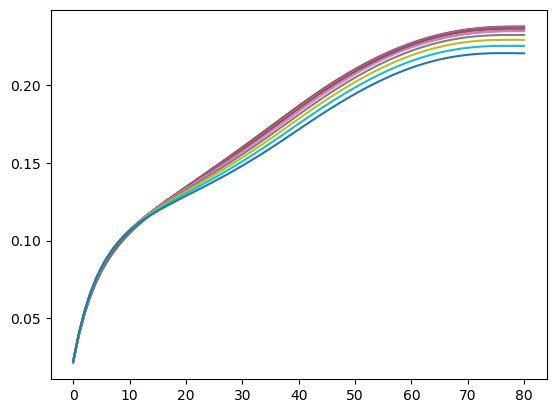

In [22]:
for (idx, ECS) in enumerate(ECS_vec)
    plot(controls[idx,:,1])
end

#### Using julia Types?
```julia
struct WorldModel
    name::String
    ECS::Float64
end

mymodel = WorldModel("test", 3.)

struct controls
    reduce::Array{Float64,1}
    remove::Array{Float64,1}
    geoeng::Array{Float64,1}
    adapt::Array{Float64,1}
end
```

